# Time Series Forecasting
### 1. Univariate Model Definition in Pytorch
 1. Linear model
 2. Feedforward Neural Network (MLP)
 3. RNN (Elman, GRU, LSTM)

### 2. Synthetic Data Example 
 1. Learning the $sin$ function
 2. Forecasting the volatility of a GARCH preocess

### 3. Multivariate Model

### 4. Real Data Example: Forecasting the distribution of the S&P500 returns using multiple features


In [0]:
import numpy
import pandas
from matplotlib import pyplot
from scipy import stats
import torch
from torch import nn, optim
from torch.distributions.normal import Normal
from tqdm import tqdm_notebook
from torch.utils.data import DataLoader, TensorDataset, Dataset, Subset
from torch.nn import Parameter, init

In [0]:
pyplot.rcParams["figure.figsize"] = (20,3)

## 1. Univariate Time series model

In [0]:
class BaseModel(nn.Module):
    def __init__(self, output_activation_fn=None):
        super().__init__()
        if output_activation_fn:
            self.output_activation_fn = getattr(torch, output_activation_fn)
        else:
            self.output_activation_fn = lambda x: x
    
    @torch.no_grad()
    def predict(self, data, device=torch.device('cpu')):
        if isinstance(data, DataLoader):
            predictions = []
            for batch_x, _ in data:
                batch_o = self.eval().forward(batch_x.to(device)).cpu()
                predictions.extend([o.item() for o in batch_o])
            return numpy.array(predictions)
        elif isinstance(data, torch.Tensor):
            return self.eval().forward(data).cpu()
        else:
            raise ValueError

### Linear Model (Generalized)

The linear model is optimized to return a linear combination of the inputs so that the specified loss function is minimized. 

$$
    f(x) = \mathbf{w}^\top \mathbf{x} + b
$$

where $\mathbf{x}=(x^{(t)},...,x^{(t-p)})$. 

Sometimes, it is appropriate to apply a transformation $g$ to the linear combination in order to optimize the model more efficiently.

$$
    f(x) = g(\mathbf{w}^\top \mathbf{x} + b)
$$

where $g$ is a non linear transformation or the identity function.

In [0]:
class GLM(BaseModel):
    def __init__(self, seq_len, **kwargs):
        super().__init__(**kwargs)
        self.linear = nn.Linear(seq_len, 1, bias=True)
        
    def forward(self, x):
        o = self.linear(x).squeeze()
        return self.output_activation_fn(o)

### Feedforward neural network

The parameters of the Neural networks are optimized to map the input to the target by applying non-linear transformation to the input allowing the model to learn more complex relation between the inputs and the targets.

\begin{align}
    \mathbf{h} =& g_1(\mathbf{W} \mathbf{x} + b_1)\\
    \hat{y} =& g_2(\mathbf{w}^\top \mathbf{h} + b_2)
\end{align}

In [0]:
class FNN(BaseModel):
    def __init__(self, seq_len, hidden_size, **kwargs):
        super().__init__(**kwargs)
        self.linear1 = nn.Linear(seq_len, hidden_size, bias=True)
        self.linear2 = nn.Linear(hidden_size, hidden_size, bias=True)
        self.linear3 = nn.Linear(hidden_size, 1, bias=True)

    def forward(self, x):
        h1 = torch.relu(self.linear1(x))
        h2 = torch.relu(self.linear2(h1))
        o = self.linear3(h2)
        return self.output_activation_fn(o).squeeze()

### Recurrent Neural Network

Elman cells:

Compute $h_p$ using the following reccurence:

$$
\begin{equation}
    \mathbf{h}_t = \tanh\left(\mathbf{W}_h \mathbf{x}_{t} + \mathbf{U}_h \mathbf{h}_{t-1} +\mathbf{b}_h\right),~i=1,...,p
\end{equation}
$$

LSTM cells:

$$
\begin{align}
        f_t &= \mathrm{sigmoid}(\mathbf{W}_f \mathbf{x}_t + U_{f} \sigma_t + b_f) \\
        i_t &= \mathrm{sigmoid}(\mathbf{W}_i \mathbf{x}_t + U_{i} \sigma_t + b_i) \\
        o_t &= \mathrm{sigmoid}(\mathbf{W}_o \mathbf{x}_t + U_{o} \sigma_t + b_o) \\
        c_t &= f_t \odot c_{t-1} + i_t \odot \tanh(\mathbf{W}_c \mathbf{x}_t + U_{c} \sigma_t + b_c) \\
        h_{t+1} &= o_t \odot \tanh(c_t)
\end{align}
$$


Then you can read the output with a linear layer $y_{t+1}$ can be compute from the hidden state $\mathbf{h}_p$:

$$    
    \begin{align}
        y_{t+1} =& g\left(\mathbf{W}_f \mathbf{h}_p + \mathbf{b}_f\right)
    \end{align}
$$


In [0]:
class RNN(BaseModel):
    def __init__(self, input_size, hidden_size, cell_type='RNN', **kwargs):
        super().__init__(**kwargs)
        rnn_cell = getattr(nn, cell_type)
        self.rnn = rnn_cell(input_size=input_size, hidden_size=hidden_size, bias=True, batch_first=True)
        self.fnn = nn.Linear(in_features=hidden_size, out_features=1)
        
    def forward(self, input):
        """
        :param input: input of shape (batch_size, seq_len, input_size): tensor containing the features of the input sequence
        """
        if input.ndim == 2:
            input = input.unsqueeze(-1)
        o, _ = self.rnn(input)
        h = o[:, -1:, :]
        return self.output_activation_fn(self.fnn(h)).squeeze()

## 2. Synthetic Data Examples

### Example 1: Learning the $\sin()$ function

#### Generate data

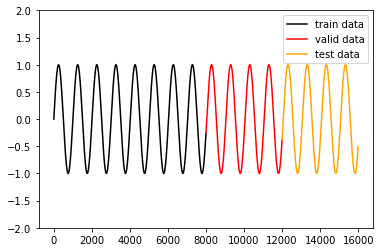

In [0]:
DATA_SIZE = 16000
TRAIN_SIZE = 8000
VALID_SIZE = 4000
TEST_SIZE = 4000

# Generate data points 
data = numpy.sin(numpy.linspace(start=0, stop=100, num=DATA_SIZE))

train_data = data[:TRAIN_SIZE]
valid_data = data[TRAIN_SIZE:TRAIN_SIZE+VALID_SIZE]
test_data = data[TRAIN_SIZE+VALID_SIZE:DATA_SIZE]

pyplot.plot(range(TRAIN_SIZE), train_data, color='black')
pyplot.plot(range(TRAIN_SIZE, TRAIN_SIZE+VALID_SIZE), valid_data, color='red')
pyplot.plot(range(TRAIN_SIZE+VALID_SIZE, DATA_SIZE), test_data, color='orange')
pyplot.ylim(-2, 2)
pyplot.legend(['train data', 'valid data', 'test data'])
pyplot.show()

#### Problem Statement

Our goal is to predice the value of the next points based on the value of the past $p$ points. 

$$
    f\colon (x^{(t)},...,x^{(t-p)})^\top \mapsto x^{(t+1)}
$$

#### Preprocessing

Currently, we have 16000 points $\mathbf{X}=(x^{(1)},...,x^{(16000)})$. A more convenient way to arrange the data for the optimization is to have each example in a different row. For example, in the case of univariate time series forecasting, the data would be rearrange this way:

$$
    \begin{pmatrix}
        x^{(1)} & \cdots & x^{(p)} \\
        x^{(2)} & \cdots & x^{(p+1)} \\
        \vdots & \ddots & \vdots \\
        x^{(T-p-1)} & \cdots & x^{(T-1)}
    \end{pmatrix}, 
    y = \begin{pmatrix}
        x^{(p+1)} \\
        x^{(p+2)} \\
        \vdots \\
        x^{(T)}
    \end{pmatrix}
$$

In [0]:
def prepare_sequential_data(data, p):
    source_data, target_data = [], []
    for i in range(p, len(data)):
        src = data[i-p:i]
        trg = data[i]
        source_data.append(src)
        target_data.append(trg)
    source_data = torch.tensor(source_data, dtype=torch.float32)
    target_data = torch.tensor(target_data, dtype=torch.float32)
    return source_data, target_data               

In [0]:
train_x, train_y = prepare_sequential_data(train_data, p=4)
print(train_x) 
print(train_y)

print(f'\ntrain_x has shape: {train_x.shape} = (TRAIN_SIZE-p-1, p)')
print(f'train_y has shape: {train_y.shape}')

tensor([[ 0.0000,  0.0063,  0.0125,  0.0188],
        [ 0.0063,  0.0125,  0.0188,  0.0250],
        [ 0.0125,  0.0188,  0.0250,  0.0312],
        ...,
        [-0.3014, -0.2954, -0.2894, -0.2834],
        [-0.2954, -0.2894, -0.2834, -0.2774],
        [-0.2894, -0.2834, -0.2774, -0.2714]])
tensor([ 0.0250,  0.0312,  0.0375,  ..., -0.2774, -0.2714, -0.2654])

train_x has shape: torch.Size([7996, 4]) = (TRAIN_SIZE-p-1, p)
train_y has shape: torch.Size([7996])


#### Optimization

We will optimize the different models such that the mean squared error between the predictions and the targetes is minimized, i.e. 

$$
    \mathcal{L}(\theta) = \sum_{t=p}^T(f(\mathbf{x}_{t:t-p}) - x^{(t+1)})^2
$$

where $\mathbf{x}_{t:t-p}=(x^{(t)},...,x^{(t-p)})^\top$

In [0]:
def train_step(x, y, model, optimizer, loss_fn):
    model.train()
    optimizer.zero_grad()
    yhat = model(x)
    assert yhat.shape == y.shape, f'The size of the output {yhat.shape} must match the size of the target {y.shape}'
    loss = loss_fn(yhat, y)
    loss.backward()
    optimizer.step()

def valid_step(x, y, model, loss_fn):
    model.eval()
    batch_size = x.shape[0]
    yhat = model(x)
    loss = loss_fn(yhat, y) * batch_size
    return loss.item()

def evaluate(dataloader, model, loss_fn, device):
    loss = 0.
    for batch_x, batch_y in dataloader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        batch_loss = valid_step(batch_x, batch_y, model, loss_fn)
        loss += batch_loss
    return loss / len(dataloader.dataset)


def train_iter(train_loader, model, optimizer, loss_fn, device):
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        train_step(batch_x, batch_y, model, optimizer, loss_fn)


def train(train_loader, valid_loader, model, optimizer, loss_fn, max_iter, device):
    best_valid_loss = float('Inf')
    with tqdm_notebook(range(max_iter), unit=' epoch', ncols=1000) as progressbar:
        for i in range(1, max_iter+1):
            train_iter(train_loader, model, optimizer, loss_fn, device)
            train_loss = evaluate(train_loader, model, loss_fn, device)
            valid_loss = evaluate(valid_loader, model, loss_fn, device)
            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
                torch.save(model.state_dict(), '/model.pth')
            progressbar.set_description(f'Iter: {i}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}')
            progressbar.update()
    model.load_state_dict(torch.load('/model.pth'))

#### Data Loader

In [0]:
def get_data_loaders(train_data, valid_data, test_data, p, train_batch_size, valid_batch_size):
    train_x, train_y = prepare_sequential_data(train_data, p=p)
    valid_x, valid_y = prepare_sequential_data(valid_data, p=p)
    test_x, test_y = prepare_sequential_data(test_data, p=p)

    train_loader = DataLoader(TensorDataset(train_x, train_y), batch_size=train_batch_size)
    valid_loader = DataLoader(TensorDataset(valid_x, valid_y), batch_size=valid_batch_size)
    test_loader = DataLoader(TensorDataset(test_x, test_y), batch_size=valid_batch_size)

    return train_loader, valid_loader, test_loader

#### Device

In [0]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device: {DEVICE}')

device: cuda


#### Experiment

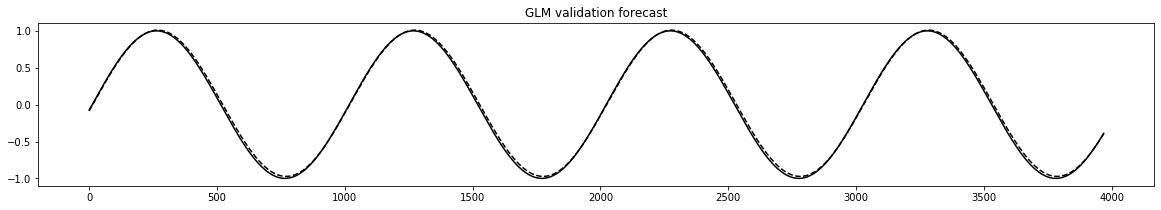

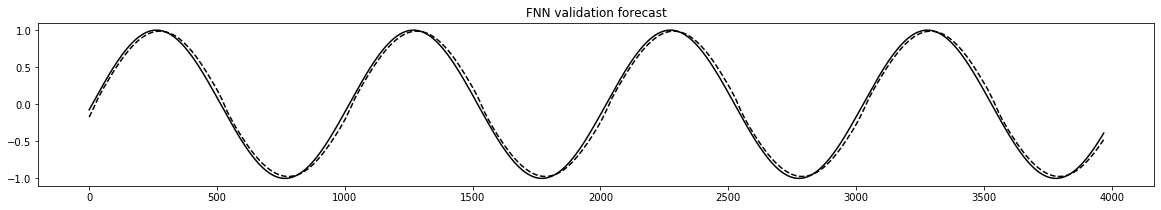

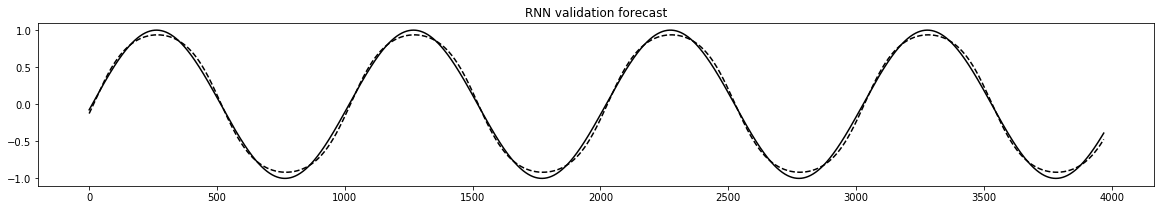

,GLM,FNN,RNN
Training MSE,0.000812,0.003435,0.002478
Validation MSE,0.000815,0.003396,0.002439


In [0]:
DATA_SIZE = 16000
TRAIN_SIZE = 8000
VALID_SIZE = 4000
TEST_SIZE = 4000

# Generate data points 
data = numpy.sin(numpy.linspace(start=0, stop=100, num=DATA_SIZE))

train_data = data[:TRAIN_SIZE]
valid_data = data[TRAIN_SIZE:TRAIN_SIZE+VALID_SIZE]
test_data = data[TRAIN_SIZE+VALID_SIZE:DATA_SIZE]

SEQ_LEN = 30
INPUT_SIZE = 1
TRAIN_BATCH_SIZE = None
VALID_BATCH_SIZE = VALID_SIZE
MAX_ITER = 100
STEP_SIZE = 0.001 # learning rate
OUTPUT_ACTIVATION = 'tanh'

HIDDEN_SIZE_FNN = 32
HIDDEN_SIZE_RNN = 32

train_x, train_y = prepare_sequential_data(train_data, p=SEQ_LEN)
valid_x, valid_y = prepare_sequential_data(valid_data, p=SEQ_LEN)

# data loader
train_loader, valid_loader, test_loader = get_data_loaders(
    train_data, valid_data, test_data, SEQ_LEN, 
    TRAIN_BATCH_SIZE if TRAIN_BATCH_SIZE else TRAIN_SIZE, 
    VALID_BATCH_SIZE if VALID_BATCH_SIZE else VALID_SIZE)

glm = GLM(seq_len=SEQ_LEN, output_activation_fn=OUTPUT_ACTIVATION).to(DEVICE)
fnn = FNN(seq_len=SEQ_LEN, hidden_size=HIDDEN_SIZE_FNN, output_activation_fn=OUTPUT_ACTIVATION).to(DEVICE)
rnn = RNN(input_size=1, hidden_size=HIDDEN_SIZE_RNN, output_activation_fn=OUTPUT_ACTIVATION).to(DEVICE)

loss_fn = torch.nn.MSELoss()

for model in [glm, fnn, rnn]:
    optimizer = torch.optim.Adam(model.parameters(), lr=STEP_SIZE)
    train(train_loader, valid_loader, model, optimizer, loss_fn, MAX_ITER, DEVICE)
    # plot_results(train_y, valid_y, train_pred, valid_pred, f'Result for model: {model_name}')

results = {'GLM': {}, 'FNN': {}, 'RNN': {}}

for model, model_name in zip([glm, fnn, rnn], ['glm', 'fnn', 'rnn']):
    train_pred = model.predict(train_loader, DEVICE)
    valid_pred = model.predict(valid_loader, DEVICE)

    results[model_name.upper()]['Training MSE'] = evaluate(train_loader, model, loss_fn, DEVICE)
    results[model_name.upper()]['Validation MSE'] = evaluate(valid_loader, model, loss_fn, DEVICE)

    #print(f'Train MSE {model_name}: {train_mse}')
    #print(f'Valid MSE {model_name}: {valid_mse}')

    pyplot.plot(valid_y, color='black')
    pyplot.plot(valid_pred, color='black', linestyle='--')
    pyplot.title(f'{model_name.upper()} validation forecast')
    pyplot.show()

pandas.DataFrame(results)

### Example 2: Stochastic Process

#### Problem statement

Given a sequence of randow variables $x_{t-p}, ..., x_{t}$, predict the distribution of the process at time $t+1$. Specifically, assuming the distribution of $x_t$ is gaussian, forecast the conditional mean and variance

$$
    x_{t+1} \sim \mathcal{N}(\hat{\mu}_{t+1}, \hat{\sigma}_{t+1})
$$

For simplicity, we will assume the distribution is centered at 0, i.e. $x_{t+1} \sim \mathcal{N}(0, \hat{\sigma}_{t+1})$

In the next example, we will not make this assumption and simultaneously predict the mean and the variance.

### Example Using a RNN
First compute $h_p$ using the following reccurence:

$$
\begin{equation}
    \mathbf{h}_i = \tanh\left(\mathbf{W}_h \mathbf{x}_{t-p+i} + \mathbf{U}_h \mathbf{h}_{i-1} +\mathbf{b}_h\right),~i=1,...,p
\end{equation}
$$
Then $\sigma_{t+1}$ can be compute from the hidden state $\mathbf{h}_p$:
$$    
    \begin{align}
        \log\sigma_{t+1} =& \mathbf{W}_f \mathbf{h}_p + \mathbf{b}_f
    \end{align}
$$

#### Objectibe function

The objective is to maximize the log-likelihood of the true observations over the predicted parameters.

$$
    \mathcal{L}(\theta) = \sum_t \log \mathcal{N}(x_t, \hat{\sigma}_t)
$$

where $\hat{\sigma}_t$ is the output of our model. 

In [0]:
def gaussian_cross_entropy(sigma, y, mu=None):
    sigma, y = sigma.squeeze(), y.squeeze()
    if mu is None:
        mu = torch.zeros_like(sigma)
    gaussian = Normal(loc=mu, scale=sigma)
    logp = gaussian.log_prob(y).mean()
    return -logp

#### Generating data from a GARCH process

To illustrate the approach, we will generate data from a GARCH process and try to learn the distribution we the model defined above.

$$
    \sigma^2_t = \omega + \sum_{i=1}^q \alpha_i x_{t-i} + \sum_{i=1}^p \beta_i \sigma^2_{t-i}
$$

$$
    x_t \sim \mathcal{N}(0, \sigma_t^2)
$$

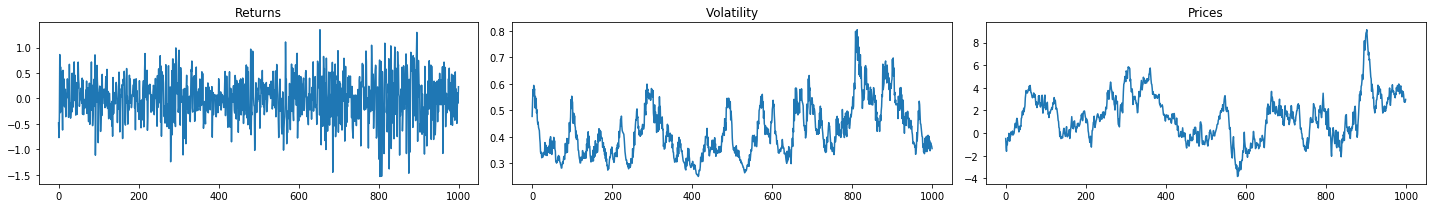

In [0]:
def generate_garch_data(omega, alpha, beta, n_out=1000):
    p = len(alpha)
    q = len(beta)

    # Since the first max(p, q) number of points are not generated from the garch
    # process, the first points are garbage (possibly extending beyond max(p, q)),
    # so we drop n_pre > max(p, q) number of points.
    n_pre = 1000
    n = n_pre + n_out

    # Sample noise
    x = numpy.random.normal(0, 1, n)

    y = numpy.zeros(n)
    sigma = numpy.zeros(n)

    # Pre-populate first max(p, q) values, because they are needed in the iteration.
    for k in range(numpy.max([p, q])):
        sigma[k] = numpy.random.normal(0, 1)
        y[k] = sigma[k] * x[k]

    # Run the garch process, notation from
    # http://stats.lse.ac.uk/fryzlewicz/lec_notes/garch.pdf
    for k in range(numpy.max([p, q]), n):
        alpha_term = sum([alpha[i] * y[k-i]**2 for i in range(p)])
        beta_term = sum([beta[i] * sigma[k-i]**2 for i in range(q)])
        sigma[k] = numpy.sqrt(omega + alpha_term + beta_term)
        y[k] = sigma[k] * x[k]

    return y[n_pre:], sigma[n_pre:]

def delta_to_cum(ys):
    ys_cum = []
    y_cum = 0
    for y in ys:
        y_cum += y
        ys_cum.append(y_cum)
    return ys_cum


# Define a garch(1,1) process
omega = 0.03
alpha = [0.0745, 0.0538, 0.0228, 0.0387, 0.0344, 0.0989, 0.0374, 0.0920, 0.0478, 0.0436]
beta = [0.0779, 0.0020, 0.0567, 0.0332, 0.0818, 0.0538, 0.0254, 0.0073, 0.0778, 0.0273]

data, sigma = generate_garch_data(omega, alpha, beta, 1000)
x = range(len(data))

# The resulting series looks like stock returns and
# the cumulative series looks like stock prices.
pyplot.subplot(1,3,1)
pyplot.plot(x, data)
pyplot.title('Returns')

pyplot.subplot(1,3,2)
pyplot.plot(x, sigma)
pyplot.title('Volatility')

pyplot.subplot(1,3,3)
pyplot.plot(x, delta_to_cum(data))
pyplot.title('Prices')

pyplot.tight_layout()
pyplot.show()

#### Experiment

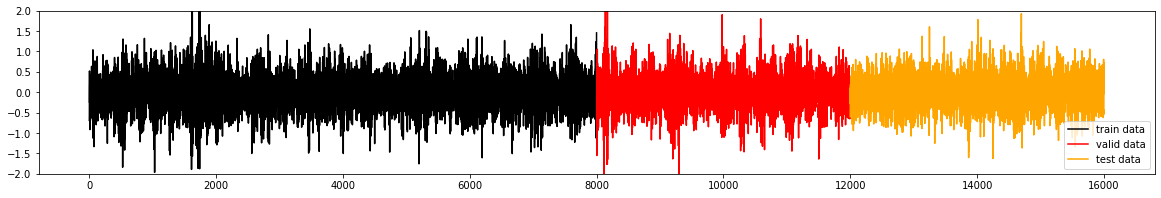

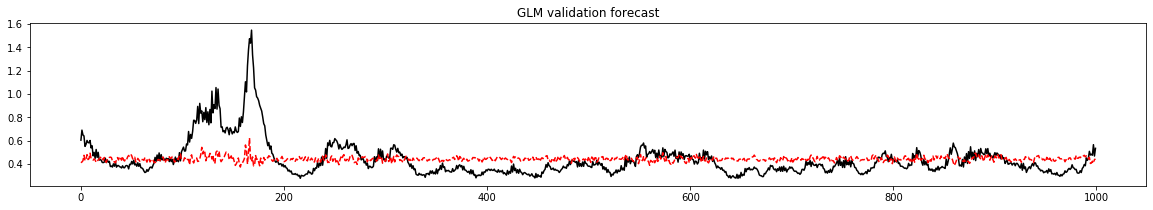

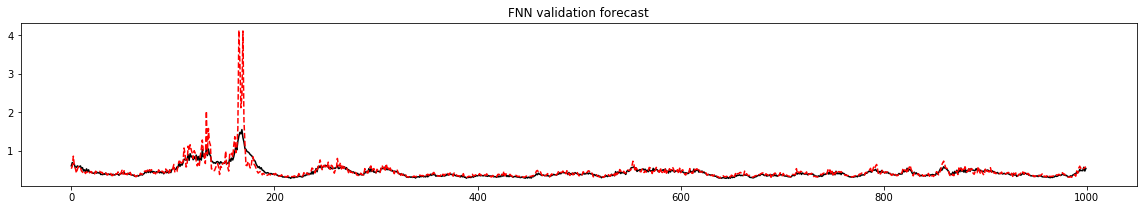

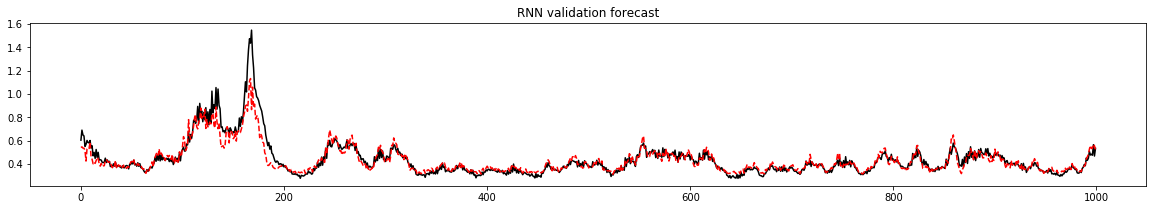

,GLM,FNN,RNN
Training Cross-Entropy,0.602852,0.533704,0.542028
Validation Cross-Entropy,0.596143,0.529635,0.528000


In [0]:
torch.manual_seed(1)
torch.backends.cudnn.deterministic = True

SEQ_LEN = 10
INPUT_SIZE = 1
TRAIN_BATCH_SIZE = 128
VALID_BATCH_SIZE = VALID_SIZE
MAX_ITER = 100
STEP_SIZE = 0.001 # learning rate
OUTPUT_ACTIVATION = 'exp'
HIDDEN_SIZE_FNN = 32
HIDDEN_SIZE_RNN = 32
CELL_TYPE = 'RNN'

DATA_SIZE = 16000
TRAIN_SIZE = 8000
VALID_SIZE = 4000
TEST_SIZE = 4000

# Generate data points 
data, sigma = generate_garch_data(omega, alpha, beta, DATA_SIZE)

train_data = data[:TRAIN_SIZE]
valid_data = data[TRAIN_SIZE:TRAIN_SIZE+VALID_SIZE]
test_data = data[TRAIN_SIZE+VALID_SIZE:DATA_SIZE]

pyplot.plot(range(TRAIN_SIZE), train_data, color='black')
pyplot.plot(range(TRAIN_SIZE, TRAIN_SIZE+VALID_SIZE), valid_data, color='red')
pyplot.plot(range(TRAIN_SIZE+VALID_SIZE, DATA_SIZE), test_data, color='orange')
pyplot.ylim(-2, 2)
pyplot.legend(['train data', 'valid data', 'test data'])
pyplot.show()

train_x, train_y = prepare_sequential_data(train_data, p=SEQ_LEN)
valid_x, valid_y = prepare_sequential_data(valid_data, p=SEQ_LEN)

# data loader
train_loader, valid_loader, test_loader = get_data_loaders(
    train_data, valid_data, test_data, SEQ_LEN, 
    TRAIN_BATCH_SIZE if TRAIN_BATCH_SIZE else TRAIN_SIZE, 
    VALID_BATCH_SIZE if VALID_BATCH_SIZE else VALID_SIZE)

glm = GLM(seq_len=SEQ_LEN, output_activation_fn=OUTPUT_ACTIVATION).to(DEVICE)
fnn = FNN(seq_len=SEQ_LEN, hidden_size=HIDDEN_SIZE_FNN, output_activation_fn=OUTPUT_ACTIVATION).to(DEVICE)
rnn = RNN(input_size=1, hidden_size=HIDDEN_SIZE_RNN, output_activation_fn=OUTPUT_ACTIVATION, cell_type=CELL_TYPE).to(DEVICE)

loss_fn = torch.nn.MSELoss()

for model in [glm, fnn, rnn]:
    optimizer = torch.optim.Adam(model.parameters(), lr=STEP_SIZE)
    train(train_loader, valid_loader, model, optimizer, gaussian_cross_entropy, MAX_ITER, DEVICE)
    # plot_results(train_y, valid_y, train_pred, valid_pred, f'Result for model: {model_name}')

results = {'GLM': {}, 'FNN': {}, 'RNN': {}}

for model, model_name in zip([glm, fnn, rnn], ['glm', 'fnn', 'rnn']):
    train_pred = model.predict(train_loader, DEVICE)
    valid_pred = model.predict(valid_loader, DEVICE)

    results[model_name.upper()]['Training Cross-Entropy'] = evaluate(train_loader, model, gaussian_cross_entropy, DEVICE)
    results[model_name.upper()]['Validation Cross-Entropy'] = evaluate(valid_loader, model, gaussian_cross_entropy, DEVICE)

    pyplot.plot(sigma[TRAIN_SIZE+SEQ_LEN:TRAIN_SIZE+1000+SEQ_LEN], color='black')
    pyplot.plot(valid_pred[:1000], color='red', linestyle='--')
    pyplot.title(f'{model_name.upper()} validation forecast')
    pyplot.show()

pandas.DataFrame(results)

## 3. Multivariate sequential model

$$
    \mathbf{X} = \begin{pmatrix}
        x_1^{(1)} & x_2^{(1)}  & \cdots & x_d^{(1)} \\
        x_2^{(2)} & x_2^{(2)} & \cdots & x_d^{(2)} \\
        \vdots & \vdots & \ddots & \vdots \\
        x_1^{(T)} & x_2^{(T)} & \cdots & x_d^{(T)}
    \end{pmatrix}
$$

### Linear model: The VAR model

$$
    f(\mathbf{x}_{t:t-p}) = g\left(b + \sum_{i=1}^p \mathbf{W}^\top_{i} \mathbf{x}_{t-i}\right)
$$

where $\mathbf{x}_t\in\mathbb{R}^{o \times d}$ and $\mathbf{x}_t\in\mathbb{R}^d$ with $o$ is the size of the output.

In [0]:
class VAR(BaseModel):
    def __init__(self, input_dim, seq_len, output_size=1, **kwargs):
        super().__init__(**kwargs)

        weight = torch.empty(size=(seq_len, input_dim, output_size), dtype=torch.float32)
        self.weight = Parameter(weight, requires_grad=True)
        init.xavier_uniform_(self.weight)

        bias = torch.empty(size=(output_size,), dtype=torch.float32)
        self.bias = Parameter(bias, requires_grad=True)
        init.constant_(self.bias, 0.)

    def forward(self, batch_input: torch.Tensor):
        assert len(batch_input.shape) == 3
        batch_input = batch_input.unsqueeze(2)
        assert batch_input.shape[1] == self.weight.shape[0]
        batch_output = batch_input.matmul(self.weight).sum(dim=1) + self.bias
        return self.output_activation_fn(batch_output.squeeze())

#### The MLP model

A mlp with one hidden layer would have the following form

\begin{align}
    \mathbf{h} =& g_1\left(b + \sum_{i=1}^p \mathbf{W}_{t-i} \mathbf{x}_{t-i}\right) \\
    f(\mathbf{x}_{t:t-p}) =& g_2\left(\mathbf{c}+\mathbf{U}\mathbf{h}\right)
\end{align}

where $\mathbf{W}_t\in \mathbb{R}^{L\times d}$ and $\mathbf{U}\in\mathbb{R}^{o\times L}$ where $L$ is the size of the hidden layer and $o$ is the size of the output.

In [0]:
class MLP(BaseModel):
    def __init__(self, input_dim, seq_len, hidden_size, **kwargs):
        super().__init__(**kwargs)
        self.var_layer = VAR(input_dim, seq_len, hidden_size)
        self.mlp_layer = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        h = torch.relu(self.var_layer(x))
        return self.output_activation_fn(self.mlp_layer(h)).squeeze()

## 4 Forecasting the distribution of the S&P500



### Download Data

In [0]:
# Download data
from google_drive_downloader import GoogleDriveDownloader
TOKEN = '112K3uzqnJNBKtUCDGXu7FvqIQ-uxkSxo'
!rm /spx_data.xlsx
GoogleDriveDownloader.download_file_from_google_drive(file_id=TOKEN, dest_path='/spx_data.xlsx')

In [0]:
spx_data = pandas.read_excel('/spx_data.xlsx')
spx_data

,tm,security_2,security_3,security_4,security_5,security_6,security_7,security_8,security_9,security_10,security_11,security_12,security_13,security_14,security_15,security_16,security_17,security_18,security_19,security_20,security_21,security_22,security_23,security_24,security_25,security_26,security_27,security_28,security_29,security_30,security_31,security_32,security_33,security_34,security_35,security_36,security_37,security_38,security_39,security_40,...,security_196,security_197,security_198,security_199,security_200,security_201,security_202,security_203,security_204,security_205,security_206,security_207,security_208,security_209,security_210,security_211,security_212,security_213,security_214,security_215,security_216,security_217,security_218,security_219,security_220,security_221,security_222,security_223,security_224,security_225,security_226,security_227,security_228,security_229,security_230,security_231,security_232,security_233,security_234,SPX
0,0.013859,0.001614,0.001919,-0.012419,-0.005600,0.009649,0.007565,-0.031759,-0.008186,-0.000709,0.021626,-0.008621,0.063927,0.039152,-0.012544,-0.001610,-0.004584,0.005307,-0.002829,0.004657,-0.009883,0.004223,0.021702,-0.033298,-0.022595,-0.017535,-0.007491,0.002549,0.001597,-0.005828,0.013980,0.004603,-0.009279,-0.011483,0.002439,0.009354,-0.001451,0.012500,-0.001264,0.006787,...,-0.000377,-0.008640,-0.015313,-0.009533,-0.003851,0.005818,-0.023190,-0.008215,-0.007602,-0.011643,-0.026080,0.061844,0.064020,-0.025070,0.026911,0.030693,-0.007059,-0.056799,-0.002981,0.024147,-0.011787,-0.024597,-0.028986,-0.015134,0.001393,0.001577,-0.000513,-0.015385,-0.011015,-0.012147,0.087334,-0.000441,-0.005252,-0.024593,0.005979,0.025956,-0.020518,0.003011,-0.010151,0.005885
1,-0.000707,0.000895,-0.000213,0.019760,-0.013194,-0.007053,0.015886,-0.010934,-0.002159,-0.036525,0.050937,-0.039232,0.012017,0.091673,-0.010586,0.039031,-0.000512,0.013373,0.008794,0.022201,-0.010169,-0.029438,0.033203,0.012500,-0.016251,0.017060,0.014717,0.002950,0.011005,-0.006188,0.053742,-0.021776,-0.001717,0.013166,0.000608,0.026685,0.000224,0.014403,0.002785,-0.013061,...,0.002264,-0.016553,-0.000723,0.036894,-0.007276,0.082905,-0.018287,-0.007530,-0.003170,-0.020681,-0.019428,0.079563,0.097473,-0.065000,-0.017272,-0.001345,-0.002187,-0.023736,-0.008259,0.046643,-0.002901,0.000000,-0.012759,-0.018379,0.005913,0.008774,0.021026,0.004518,-0.018298,0.030312,0.130782,0.037086,-0.016320,0.021046,0.065527,0.063248,0.004189,0.002001,-0.006285,0.009194
2,-0.004953,-0.001789,0.011066,0.015561,0.005381,-0.008478,0.034842,0.017007,-0.009926,0.023555,0.006085,0.021680,0.004665,-0.005935,-0.037090,0.002591,-0.001706,0.006077,0.022357,0.016945,0.005518,0.002786,0.010180,0.013443,-0.002094,0.041548,0.027520,0.005882,0.006626,0.007647,0.028037,-0.008904,-0.010790,0.029238,-0.012766,0.045016,-0.002235,0.000406,-0.010603,-0.008965,...,0.010166,-0.003572,0.029316,0.005879,0.037563,0.073591,0.006863,0.005311,0.003180,0.018712,0.011780,0.003372,0.002412,0.023682,0.057576,-0.030204,0.014615,0.022512,0.008040,0.082762,-0.020369,0.004348,-0.013411,0.003376,-0.012794,-0.001115,0.048217,0.066342,-0.025122,0.058840,-0.005950,-0.011069,-0.008133,0.038776,-0.029145,0.054019,-0.007060,0.019471,-0.016312,0.006213
3,0.000948,-0.006991,0.006104,0.002891,0.005514,0.015715,-0.003181,-0.033445,-0.012853,0.001259,-0.022941,0.024722,-0.033347,-0.010615,-0.005185,0.017571,-0.021368,0.001381,-0.013203,0.031448,-0.007379,-0.007716,-0.006125,-0.000541,-0.003264,0.015857,-0.019182,-0.023977,0.023351,-0.008023,0.006234,-0.011057,-0.008536,-0.013182,-0.011700,-0.002564,0.004703,-0.007705,-0.003572,-0.026061,...,-0.002609,-0.014272,-0.010900,0.011689,0.033775,-0.041459,-0.000649,0.037736,-0.015848,0.026502,0.008732,-0.014402,-0.023846,-0.012836,0.022350,-0.063678,-0.001981,0.012770,-0.000570,-0.012212,0.003630,-0.006061,-0.012605,0.011013,0.000701,-0.014959,0.032583,-0.028120,-0.034913,-0.024902,-0.123083,-0.010762,-0.004920,0.018664,-0.026860,-0

### Problem Statement

Given the last $p$ returns of $d$ securities included in the S&P500, forecast the distribution of the S&P500 returns.

The inputs have the following shape 

$$
    \mathbf{x}_{t:t-p} = \begin{pmatrix}
        x_1^{(t-p)} & x_2^{(t-p)}  & \cdots & x_d^{(t-p)} \\
        x_2^{(t-p+1)} & x_2^{(t-p+1)} & \cdots & x_d^{(t-p+1)} \\
        \vdots & \vdots & \ddots & \vdots \\
        x_1^{(t)} & x_2^{(t)} & \cdots & x_d^{(t)}
    \end{pmatrix}
$$

and we are looking for a function $f$ that maps the input to the the parameter of the distribution on step ahead

$$
    \begin{pmatrix}\hat{\mu}_{t+1} \\ \hat{\sigma}_{t+1}\end{pmatrix} = f(\mathbf{x}^{(t)})
$$

#### preprocessing

$$
    x_i^{(t)} = \log \left(\frac{p_i^{(t)}}{p_i^{(t-1)}}\right)
$$

### Volatility Model

In [0]:
class GaussianNet(nn.Module):
    def __init__(self, volatility_model, mean_model=None):
        super().__init__()
        self.mean_model = mean_model
        self.volatility_model = volatility_model

    def forward(self, x):
        sigma = self.volatility_model(x).squeeze()
        if self.mean_model is not None:
            mu = self.mean_model(x).squeeze()
        else:
            mu = None
        return mu, sigma

### Preprocessing & Dataloader

In [0]:
def make_sequential_data(data, history_size):
    seq_data = []

    for i in range(history_size, len(data) + 1):
        seq = data[i - history_size:i]
        seq_data.append(seq)

    seq_data = numpy.array(seq_data, dtype=numpy.float32)
    return seq_data

def preprocess_data(data, target_columns, input_lag):
    input_data = data.values[:-1]
    input_data = make_sequential_data(input_data, input_lag)
    label_data = data[target_columns].values
    label_data = label_data[input_lag:]
    return input_data.astype(numpy.float32), label_data.astype(numpy.float32)

def preprocess_sequential_data_for_training(data_path, target_columns, input_lag,):
    data = pandas.read_excel(data_path)
    input_data, label_data = preprocess_data(
        data,
        target_columns=target_columns,
        input_lag=input_lag
    )
    return input_data, label_data

In [0]:
X, y = preprocess_sequential_data_for_training('/spx_data.xlsx', target_columns='SPX', input_lag=10)

X.shape, y.shape

((4269, 10, 235), (4269,))

In [0]:
class SpxDataset(Dataset):
    def __init__(self, data_path, input_lag, target_column='SPX'):
        self.input_lag = input_lag
        self.input_data, self.label_data = preprocess_sequential_data_for_training(data_path=data_path, input_lag=input_lag, target_columns=target_column)

    def __getitem__(self, ix):
        source_sample = numpy.array(self.input_data[ix])  # source_lag x source_dim
        target_sample = numpy.array(self.label_data[ix])  # target_lag x target_dim
        return source_sample.astype(numpy.float32), target_sample.astype(numpy.float32)

    def __len__(self):
        return len(self.input_data)

    @property
    def input_dim(self):
        return self[0][0].shape[-1]

### Simple Unit Testing

In [0]:
spx_dataset = SpxDataset('/spx_data.xlsx', 10, 'SPX')
spx_dataset[0]

In [0]:
spx_dataloader = DataLoader(spx_dataset, batch_size=128)

batch_x, batch_y = next(iter(spx_dataloader))

batch_x.shape, batch_y.shape

(torch.Size([128, 10, 235]), torch.Size([128]))

In [0]:
var = VAR(input_dim=235, seq_len=10)
mlp = MLP(input_dim=235, seq_len=10, hidden_size=32)
rnn = RNN(input_size=235, hidden_size=32)

for model in [var, mlp, rnn]:
    unit_test_pred_var = var(batch_x)
    assert unit_test_pred_var.shape == torch.Size([128]), f'model: \n{model}\n ouptut shape: {unit_test_pred_var.shape}'

    gaussian_cross_entropy(unit_test_pred_var, batch_y)

print('Everything seems OK')

Everything seems OK


#### Experiment

In [0]:
def new_train_step(x, y, model, optimizer, loss_fn):
    model.train()
    optimizer.zero_grad()
    mu, sigma = model(x)
    loss = loss_fn(sigma, y, mu)
    loss.backward()
    optimizer.step()

def new_valid_step(x, y, model, loss_fn):
    model.eval()
    batch_size = x.shape[0]
    mu, sigma = model(x)
    loss = loss_fn(sigma, y, mu) * batch_size
    return loss.item()

def new_evaluate(dataloader, model, loss_fn, device):
    loss = 0.
    for batch_x, batch_y in dataloader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        batch_loss = new_valid_step(batch_x, batch_y, model, loss_fn)
        loss += batch_loss
    return loss / len(dataloader.dataset)


def new_train_iter(train_loader, model, optimizer, loss_fn, device):
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        new_train_step(batch_x, batch_y, model, optimizer, loss_fn)


def new_train(train_loader, valid_loader, model, optimizer, loss_fn, max_iter, device):
    best_valid_loss = float('Inf')
    with tqdm_notebook(range(max_iter), unit=' epoch', ncols=1000) as progressbar:
        for i in range(1, max_iter+1):
            new_train_iter(train_loader, model, optimizer, loss_fn, device)
            train_loss = new_evaluate(train_loader, model, loss_fn, device)
            valid_loss = new_evaluate(valid_loader, model, loss_fn, device)
            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
                torch.save(model.state_dict(), '/model.pth')
            progressbar.set_description(f'Iter: {i}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}')
            progressbar.update()
    model.load_state_dict(torch.load('/model.pth'))

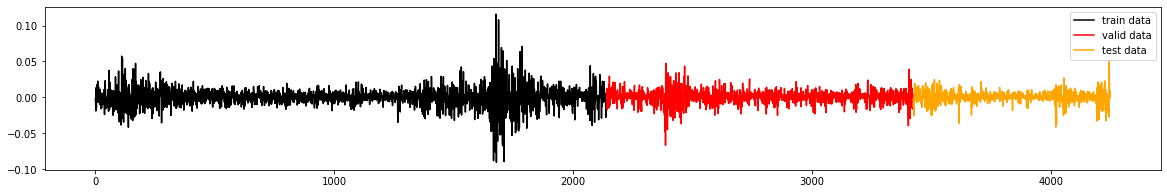

Training model
GaussianNet(
  (volatility_model): VAR()
)



Training model
GaussianNet(
  (volatility_model): MLP(
    (var_layer): VAR()
    (mlp_layer): Linear(in_features=32, out_features=1, bias=True)
  )
)



Training model
GaussianNet(
  (volatility_model): RNN(
    (rnn): GRU(235, 32, batch_first=True)
    (fnn): Linear(in_features=32, out_features=1, bias=True)
  )
)


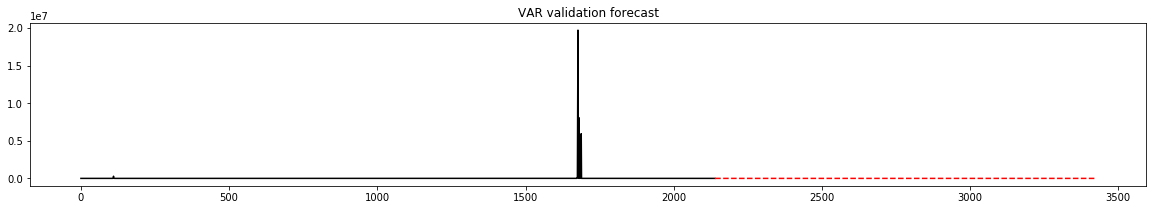

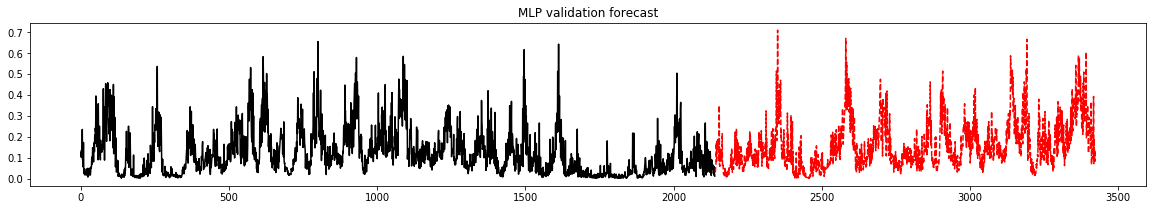

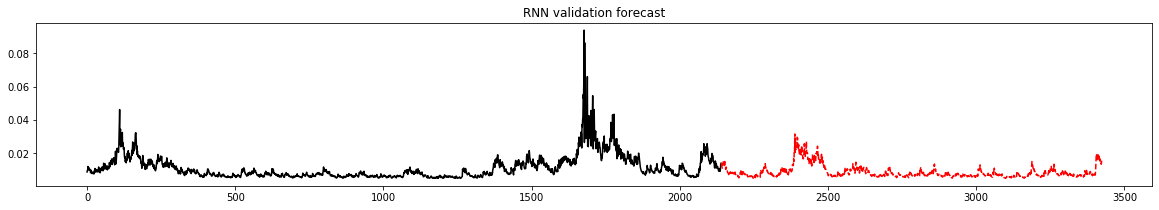

,VAR,MLP,RNN
Training Cross-Entropy,-0.591244,-1.528454,-3.187628
Validation Cross-Entropy,-0.212836,-0.971822,-3.389975


In [0]:
torch.manual_seed(1)
torch.backends.cudnn.deterministic = True

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SEQ_LEN = 30
INPUT_SIZE = 235
MAX_ITER = 500
STEP_SIZE = 0.001 # learning rate
OUTPUT_ACTIVATION = 'exp'
CELL_TYPE = 'GRU'

DATA_SIZE = len(spx_data)
TRAIN_SIZE = round(0.5*DATA_SIZE)
VALID_SIZE = round(0.3*DATA_SIZE)
TEST_SIZE = DATA_SIZE - TRAIN_SIZE - VALID_SIZE
TRAIN_BATCH_SIZE = None
VALID_BATCH_SIZE = VALID_SIZE


# Prepare Data
spx_dataset = SpxDataset('/spx_data.xlsx', SEQ_LEN, 'SPX')
train_loader = DataLoader(Subset(spx_dataset, indices=range(TRAIN_SIZE)), batch_size=TRAIN_BATCH_SIZE if TRAIN_BATCH_SIZE else TRAIN_SIZE)
valid_loader = DataLoader(Subset(spx_dataset, indices=range(TRAIN_SIZE, TRAIN_SIZE+VALID_SIZE)), batch_size=VALID_SIZE)
test_loader = DataLoader(Subset(spx_dataset, indices=range(TRAIN_SIZE+VALID_SIZE, DATA_SIZE)), batch_size=TEST_SIZE)

train_target = train_loader.dataset.dataset.label_data[:TRAIN_SIZE]
valid_target = valid_loader.dataset.dataset.label_data[TRAIN_SIZE:TRAIN_SIZE+VALID_SIZE]
test_target = test_loader.dataset.dataset.label_data[TRAIN_SIZE+VALID_SIZE:DATA_SIZE]

pyplot.plot(range(TRAIN_SIZE), train_target, color='black')
pyplot.plot(range(TRAIN_SIZE, TRAIN_SIZE+VALID_SIZE), valid_target, color='red')
pyplot.plot(range(TRAIN_SIZE+VALID_SIZE, DATA_SIZE-SEQ_LEN), test_target, color='orange')
# pyplot.ylim(-2, 2)
pyplot.legend(['train data', 'valid data', 'test data'])
pyplot.show()

HIDDEN_SIZE_FNN = 32
HIDDEN_SIZE_RNN = 32

var = GaussianNet(
    mean_model=None, 
    volatility_model=VAR(seq_len=SEQ_LEN, input_dim=INPUT_SIZE, output_activation_fn='exp').to(DEVICE)
).to(DEVICE)

mlp = GaussianNet(
    mean_model=None, 
    volatility_model=MLP(seq_len=SEQ_LEN, input_dim=INPUT_SIZE, hidden_size=HIDDEN_SIZE_FNN, output_activation_fn='exp').to(DEVICE)
).to(DEVICE)

rnn = GaussianNet( 
    mean_model=None,
    volatility_model=RNN(input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE_RNN, output_activation_fn='exp', cell_type='GRU').to(DEVICE)
).to(DEVICE)

loss_fn = gaussian_cross_entropy

for model in [var, mlp, rnn]:
    print('Training model\n{}'.format(model))
    optimizer = torch.optim.Adam(model.parameters(), lr=STEP_SIZE)
    new_train(train_loader, valid_loader, model, optimizer, loss_fn, MAX_ITER, DEVICE)
    # plot_results(train_y, valid_y, train_pred, valid_pred, f'Result for model: {model_name}')

results = {'VAR': {}, 'MLP': {}, 'RNN': {}}

for model, model_name in zip([var, mlp, rnn], ['var', 'mlp', 'rnn']):
    train_pred = model.volatility_model.predict(train_loader, DEVICE)
    valid_pred = model.volatility_model.predict(valid_loader, DEVICE)

    results[model_name.upper()]['Training Cross-Entropy'] = new_evaluate(train_loader, model, gaussian_cross_entropy, DEVICE)
    results[model_name.upper()]['Validation Cross-Entropy'] = new_evaluate(valid_loader, model, gaussian_cross_entropy, DEVICE)

    pyplot.plot(range(len(train_pred)), train_pred, color='black')
    pyplot.plot(range(len(train_pred), len(train_pred)+len(valid_pred)), valid_pred, color='red', linestyle='--')
    pyplot.title(f'{model_name.upper()} validation forecast')
    pyplot.show()

pandas.DataFrame(results)